(sentinel-1-surfmi)=
# Sentinel-1 Surface Moisture Index (SurfMI)

Direct link to this notebook: [here](https://github.com/Jena-Earth-Observation-School/sdc-tools/blob/main/docs/content/02/05_00_S1_SurfMI.ipynb)

## Product description

The Sentinel-1 Surface Moisture Index (SurfMI) is derived from the {ref}`sentinel-1` 
product. It is a measure of the relative surface moisture, based on the 
assumption that short-term variations of the radar backscatter signal are 
associated with moisture variations, while long-term changes can be related to 
vegetation and surface roughness. The SurfMI $m_s(t)$ is calculated as:

$$
m_s(t)=\frac{\sigma^0(t)-\sigma_{dry}^0(t)}{\sigma_{wet}^0(t)-\sigma_{dry}^0(t)} * 100
$$

where $\sigma^0(t)$ is a backscatter time series, $\sigma_{dry}^0(t)$ the dry 
reference (permanent wilting level) and $\sigma_{wet}^0(t)$ the wet reference 
(field capacity) ([Urban et al., 2018](https://doi.org/10.3390/rs10091482)). 
For the dry and wet references, the 5th and 95th percentile of the backscatter 
time series are used, respectively. These layers have been pre-computed for each 
SALDi site based on the available Sentinel-1 RTC VV-polarised backscatter data 
so that the SurfMI can be efficiently calculated on the fly.

The product abbreviation used in this package is `s1_surfmi`.

## Loading data

In [8]:
from sdc.load import load_product

vec = '../../_assets/vec_01_05_01.geojson'
time_range=("2018-01-01", "2023-01-01")
ds = load_product(product="s1_surfmi", vec=vec, time_range=time_range)
ds

<xarray.DataArray (time: 385, latitude: 131, longitude: 147)>
dask.array<where, shape=(385, 131, 147), dtype=float32, chunksize=(385, 131, 147), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 -25.06 -25.06 -25.06 ... -25.08 -25.08
  * longitude    (longitude) float64 31.47 31.47 31.47 31.47 ... 31.5 31.5 31.5
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2018-01-03T16:30:28.531898 ... 2022-12...
Attributes:
    dry_reference:  site06_vv_q05__20180103T163028_20230903T163910.tif
    wet_reference:  site06_vv_q95__20180103T163028_20230903T163910.tif

## Comparison with precipitation data

Let's compare the SurfMI with the {ref}`mswep` precipitation data. Instead of 
loading this product using the same vector file as above, we will load it for 
the entire SALDi site and then select the central coordinate of the vector file. 
This is a workaround for [this issue](https://github.com/Jena-Earth-Observation-School/sdc-tools/issues/27),
which results in an empty DataArray if the area of interest is smaller than a 
single pixel of the MSWEP product.

In [15]:
import fiona

# Load MSWEP data
mswep = load_product(product="mswep", vec="site06", time_range=time_range)

# Get the center coordinate of the vector file
with fiona.open(vec) as src:
    bounds = src.bounds
    lon = (bounds[0] + bounds[2]) / 2
    lat = (bounds[1] + bounds[3]) / 2

# Select the nearest grid point to the center coordinate
mswep_pt = mswep.sel(latitude=lat, longitude=lon, method='nearest')
mswep_pt

<xarray.DataArray 'precipitation' (time: 1825)>
array([ 0.375    ,  1.6875   ,  0.       , ...,  2.7890625, 17.882812 ,
        6.015625 ], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31
    longitude    float32 31.45
    latitude     float32 -25.05
    spatial_ref  int32 4326
Attributes:
    units:    mm d-1

For the plot we calculate the mean and standard deviation for each time step of 
the SurfMI data by aggregating over the spatial dimensions (latitude and 
longitude):

In [16]:
ds_mean = ds.mean(dim=['latitude', 'longitude'])
ds_std = ds.std(dim=['latitude', 'longitude'])

ds_mean

<xarray.DataArray (time: 385)>
dask.array<mean_agg-aggregate, shape=(385,), dtype=float32, chunksize=(385,), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2018-01-03T16:30:28.531898 ... 2022-12...
Attributes:
    dry_reference:  site06_vv_q05__20180103T163028_20230903T163910.tif
    wet_reference:  site06_vv_q95__20180103T163028_20230903T163910.tif

Text(0.5, 1.0, ' Sentinel-1 SurfMI vs. MSWEP precipitation')

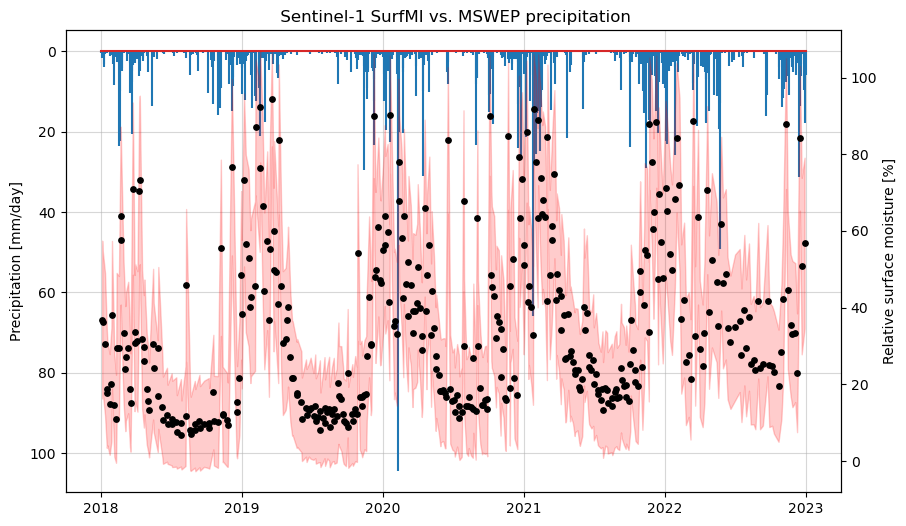

In [26]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.stem(mswep_pt.time, mswep_pt, markerfmt="")
ax.grid(True, alpha=0.5)
ax.set_ylabel("Precipitation [mm/day]")
ax.invert_yaxis()

ax2 = ax.twinx()
ax2.fill_between(ds_mean.time, ds_mean - ds_std, ds_mean + ds_std, color='red', alpha=0.2)
ax2.scatter(ds_mean.time, ds_mean, color='black', s=15)
ax2.set_ylabel("Relative surface moisture [%]")

plt.xlabel("Time")
plt.title(" Sentinel-1 SurfMI vs. MSWEP precipitation")